# Phase 2ii: TreeTime & Down Sampling

Generates temporal tree using TreeTime and if down_sample_to is provided performs downsampling.

<details>
    <summary>Click To See A Decription of Parameters</summary>
        <pre>
            <code>
save_dir: str  
    Path to directory for saving outputs in.

fasta_file: str, optional
    Path to fasta file containing sequences to use in generating a BEAST 2 xml.
    If not given and root_strain_names is not given is used instaedf'{save_dir}/sequences.fasta'
    If not given and root_strain_names is given f'{save_dir}/sequences_with_root.fasta' is used instead.

metadata_path: str
    Path to csv or tsv containing metadata pertaining to fasta_file.
    If not given and root_strain_names is not given is used instaedf'{save_dir}/metadata.csv'
    If not given and root_strain_names is given f'{save_dir}/metadata_with_root.csv' is used instead.

sample_id_field: str, default 'strain'
    Name of field in metadata_path containing ids corresponding to those used in fasta_file.

collection_date_field: str, default 'date'
    Name of field in metadata_pathcontaining collection dates of sequences. Should be format YYYY-MM-DD.

root_strain_names: list of strings, optional
    IDs of sequences used to root 'Temporal' initial_tree removed from fasta file and initial tree file used to generate
    the BEAST 2 xml.

down_sample_to: int, optional
    If provided the fasta file and initial tree file used to generate the BEAST 2 xml is downsampled to this amount.
    If downsampling occurs the following are saved in save_dir and used in generating a BEAST 2 xml in phase 4:
        down_sampled_time.nwk: A downsampled temporal tree.
        down_sampled_sequences.fasta: Fasta file containing downsamplec sequences.
        down_sampled_metadata.csv: the down sampled metadata.
  </code>
</pre>


In [1]:
save_dir = None
fasta_path=None
metadata_path=None
sample_id_field = 'strain'
collection_date_field = 'date'
root_strain_names = None
down_sample_to= None

In [2]:
# Parameters
collection_date_field = "sample collection date"
down_sample_to = 100
fasta_path = "example_data/COVID-19_JN.1/VirusSeq_JN1_alignment.fasta"
metadata_path = "example_data/COVID-19_JN.1/VirusSeq_JN1_metadata.csv"
root_strain_names = None
sample_id_field = "specimen collector sample ID"
save_dir = "Local-Test-BDSKY-Rt_change_times/2025-11-10_13-28-02"
cache_dir = "Local-Test-BDSKY-Rt_change_times/2025-11-10_13-28-02/cache"


### Import packages and get data if not in save_dir

In [3]:
from beast_pype.tree_time_scale import timescale, temporal_pruning_sampler, plot_root_to_tip, tree_nodes_CI
from beast_pype.date_utilities import decimal_to_date
from Bio import Phylo, SeqIO
import os
import pandas as pd
import ete3
import yaml
from copy import deepcopy

Matplotlib created a temporary cache directory at /tmp/matplotlib-r8_pknr0 because the default path (/home/CSCScience.ca/mgrunnill/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
if metadata_path is None:
    if root_strain_names is None: 
        metadata_path = f'{save_dir}/metadata.csv'
    else:
        metadata_path = f'{save_dir}/metadata_with_root.csv'
    if not os.path.isfile(metadata_path):
        raise FileNotFoundError(f'If metadata_path is not given the the save_dir directory `{save_dir}` must contain either the file "metadata.csv" or the file "metadata_with_root.csv" (if root_strain_names is given). ')
        
if fasta_path is None:
    if root_strain_names is None: 
        fasta_path = f'{save_dir}/sequences.fasta'
    else:
        fasta_path = f'{save_dir}/sequences_with_root.fasta'
    if not os.path.isfile(fasta_path):
        raise FileNotFoundError(f'If fasta_path is not given the the save_dir directory `{save_dir}` must contain either the file "sequences.fasta" or the file "sequences_with_root.fasta" (if root_strain_names is given).')

## Generating time trees

In [5]:
if root_strain_names is None:
    time_tree, bad_tips = timescale(
        ftree=f'{save_dir}/initial_trees/iqtree.nwk',
        falignment=fasta_path,
        fdates=metadata_path,
        remove_root=False,
        sample_id_field=sample_id_field,
        collection_date_field=collection_date_field        
    )
else:
    time_tree, bad_tips = timescale(
            ftree=f'{save_dir}/initial_trees/iqtree.nwk',
            falignment=fasta_path,
            fdates=metadata_path,
            reroot=root_strain_names,
            sample_id_field=sample_id_field,
            collection_date_field=collection_date_field        
        )
    

Phylo.write(time_tree.tree,
                f'{save_dir}/initial_trees/full_time.nwk',
                format='newick',
                format_branch_length='%1.8f')


Attempting to parse dates...
	Using column 'specimen collector sample ID' as name. This needs match the taxon names in the tree!!
	Using column 'sample collection date' as date.



21.99	TreeTime.reroot: with method or node: least-squares

22.00	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.



29.02	###TreeTime.run: INITIAL ROUND



39.22	TreeTime.reroot: with method or node: least-squares

39.22	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.



40.75	###TreeTime.run: rerunning timetree after rerooting



54.68	###TreeTime.run: ITERATION 1 out of 2 iterations



93.25	###TreeTime.run: ITERATION 2 out of 2 iterations


1

## Saving the Time Tree's Stats

Root-to-tip figure.

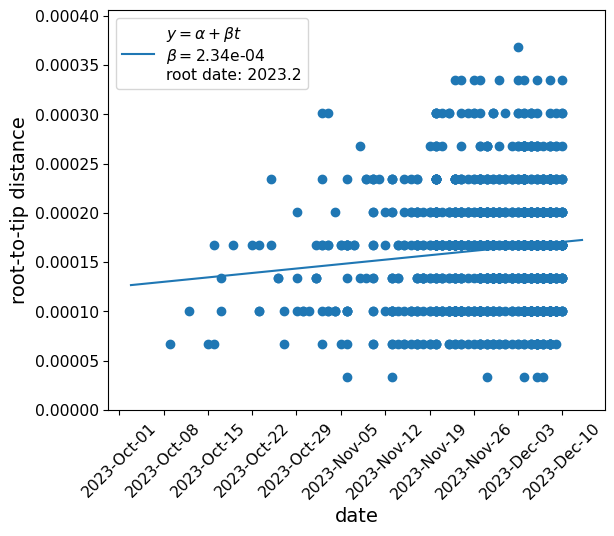

In [6]:
fig, ax = plot_root_to_tip(time_tree)
fig.savefig(f'{save_dir}/initial_trees/full_time_root_to_tip.png')

Node confidence table

In [7]:
node_ci_df = tree_nodes_CI(time_tree, fraction=0.95)
node_ci_df.to_csv(f'{save_dir}/initial_trees/full_time_node_confidence.csv', index=False)

Clock model stats

In [8]:
clock_model = deepcopy(time_tree.clock_model)
clock_model ['TMRCA root (year decimal)'] = -clock_model['intercept']/clock_model['slope']
clock_model ['TMRCA root (date)'] = decimal_to_date(clock_model ['TMRCA root (year decimal)']).strftime('%y-%m-%d')
clock_model ['R^2 value'] = clock_model['r_val']**2
clock_model['Correlation Coefficient (rho or r)'] = clock_model.pop('r_val')
with open(f'{save_dir}/initial_trees/full_time_clock_model_stats.yml', 'w') as yaml_file:
    yaml.dump(clock_model, yaml_file, default_flow_style=False)


## Downsampling time trees

### Obtaining strain ids and sequences.

Below, if the sample size is over suggested_down_sample_tos then the normalised residuals from the root-to-tip regression above are used as weights in a probabilistic draw to remove leaves from a list of all the tips. The tips that are left to keep are stored in a list. See beast_pype.tree_time_scale.temporal_pruning_sampler for details on weighted removal of tips method.

In [9]:
if down_sample_to is not None:
    strain_sequences = SeqIO.parse(fasta_path, 'fasta')
    metadata_df = pd.read_csv(metadata_path, parse_dates=[collection_date_field])
    tips = time_tree.tree.get_terminals()
    n_tips = len(tips)
    if down_sample_to < n_tips:
        stuff_to_add = True
        str_down_sample_to = str(down_sample_to)
        sampled_ids = temporal_pruning_sampler(time_tree=time_tree, sample_size=down_sample_to)
        tree = ete3.Tree(f'{save_dir}/initial_trees/full_time.nwk', format=1)
        tree.prune(sampled_ids,  preserve_branch_length=True)
        tree.write(outfile=f'{save_dir}/initial_trees/down_sampled_time.nwk',format=1)
        selected_metadata = metadata_df[metadata_df[sample_id_field].isin(sampled_ids)]
        selected_seqs = [seq_record for seq_record in strain_sequences if seq_record.id in sampled_ids]
        selected_metadata.to_csv(f'{save_dir}/down_sampled_metadata.csv', index=False)
        with open(f'{save_dir}/down_sampled_sequences.fasta', 'w') as handle:
            SeqIO.write(selected_seqs, handle, 'fasta')
